In [36]:
%matplotlib inline
from IPython.core.display import display
from itertools import combinations
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas
import numpy
from scipy.stats import skew, kurtosis

In [37]:
df = pandas.read_csv('../data/train.csv')

In [38]:
with open('tfidf_all_pred2_5.pkl', 'rb') as f:
    x = pickle.load(f).astype(numpy.float32)
df['pred'] = x

In [39]:
avg_pos = df[df['is_duplicate'] == 1]['pred'].mean()
avg_neg = df[df['is_duplicate'] == 0]['pred'].mean()

In [40]:
import networkx as nx
G = nx.Graph()

edges = [tuple(x) for x in df[['question1', 'question2', 'pred']].values]
G.add_weighted_edges_from(edges)
#G.add_weighted_edges_from(add_edges)
map_score = dict(((x[0], x[1]), x[2]) for x in df[['question1', 'question2', 'pred']].values)
map_dup = dict(((x[0], x[1]), x[2]) for x in df[['question1', 'question2', 'is_duplicate']].values)

In [41]:
cliques = sorted(list(nx.find_cliques(G)), key=lambda x: (len(x), max(map(str, x))))

In [42]:
import copy
from itertools import combinations
cnt = 0
map_result = copy.deepcopy(map_score)
map_cnum = {}
map_data = {}

for cli in tqdm(cliques):
    #if len(cli) < 3:
    #    continue
    keys = {}
    for q1, q2 in combinations(cli, 2):
        if (q1, q2) in map_score:
            keys[q1, q2] = map_score[q1, q2]
        elif (q2, q1) in map_score:
            keys[q2, q1] = map_score[q2, q1]

    val_max = numpy.max(list(keys.values()))
    val_min = numpy.min(list(keys.values()))
    val_avg = numpy.mean(list(keys.values()))
    """
    val_med = numpy.median(list(keys.values()))
    val_std = numpy.std(list(keys.values()))
    val_skew = skew(list(keys.values()))
    val_kurt = kurtosis(list(keys.values()))
    """
    
    if val_avg > 0.4:#avg_pos:
        val = val_max
        keys = {k: numpy.max([val, map_result[k]]) for k in keys}
    elif val_avg > 0.05:
        val = val_avg
        keys = {k: numpy.max([val, map_result[k]]) for k in keys}
    else:
        val = val_min
        keys = {k: numpy.min([val, map_result[k]]) for k in keys}

    map_result.update(keys)
    keys = {k: len(cli) for k in keys}
    map_cnum.update(keys)
    keys = {k: (val_max, val_min, val_avg) for k in keys}
    map_data.update(keys)

In [43]:
list_res = []
use_cols = ['cnum', 'pred', 'new', 'vmax', 'vmin', 'vavg'] #, 'vmed', 'vstd', 'vskew', 'vkurt']
for key, new in map_result.items():
    #new = map_result[key]
    try:
        label = map_dup[key]
    except:
        continue
    pred = map_score[key]
    cnum = map_cnum.get(key, -1)
    data = list(map_data[key])
    new_pred = new
    list_res.append([ label, cnum,pred, new_pred] + data)
aaa = pandas.DataFrame(list_res, columns=['label'] + use_cols)

from tfidf_k import calc_weight
from sklearn.metrics import log_loss, roc_auc_score
sw = calc_weight(aaa['label'].values)
print(roc_auc_score(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(roc_auc_score(aaa['label'].values, aaa['new'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['new'].values, sample_weight=sw))

0.960911438918
0.181255819478
0.967923431028
0.164737368167


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75616022e8>]], dtype=object)

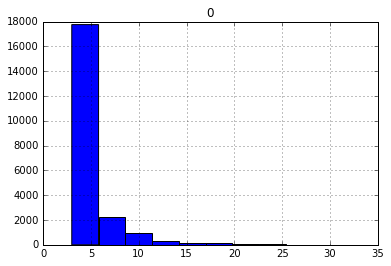

In [44]:
pandas.DataFrame([len(c) for c in cliques if len(c) > 2]).hist()

In [45]:
sw2 = sw / sw.sum() * aaa['label'].shape[0]
aaa['error'] = -1 * ( aaa['label'] * numpy.log( aaa['new']) + (1-aaa['label']) * numpy.log(1 - aaa['new']))
aaa['error_sw'] = aaa['error']  * sw2

aaa['error2'] = -1 * ( aaa['label'] * numpy.log( aaa['pred']) + (1-aaa['label']) * numpy.log(1 - aaa['pred']))
aaa['error2_sw'] = aaa['error2'] * sw2

aaa['tmp'] = numpy.where(aaa['cnum'] > 8, 0.9999, aaa['new'].values)
aaa['error3'] = -1 * ( aaa['label'] * numpy.log( aaa['tmp']) + (1-aaa['label']) * numpy.log(1 - aaa['tmp']))
aaa['error3_sw'] = aaa['error3'] * sw2

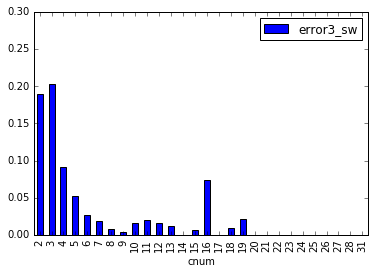

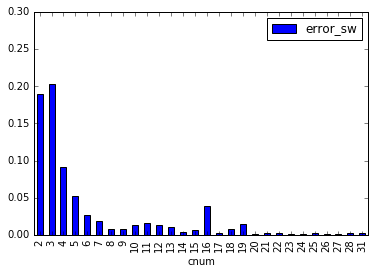

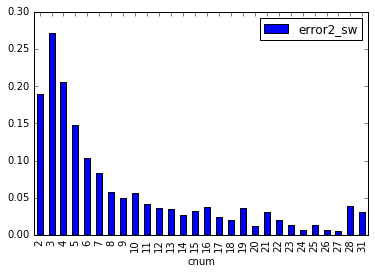

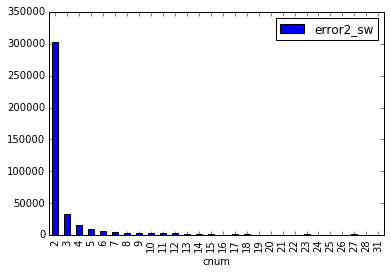

In [46]:
display(aaa.groupby('cnum')[['error3_sw']].mean().plot(kind='bar', ylim=(0, 0.3)))
display(aaa.groupby('cnum')[['error_sw']].mean().plot(kind='bar', ylim=(0, 0.3)))
display(aaa.groupby('cnum')[['error2_sw']].mean().plot(kind='bar', ylim=(0, 0.3)))
display(aaa.groupby('cnum')[['error2_sw']].count().plot(kind='bar'))

In [47]:
aaa.to_csv('clique_data.csv', index=False)

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.tree.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm.sklearn import LGBMClassifier
#use_col = ['cnum', 'pred', 'new', 'vmax','vmin', 'vavg']
#final_tree = DecisionTreeClassifier(max_depth=6, random_state=0, min_samples_leaf=1000, criterion='gini')
#final_tree =  LGBMClassifier(max_depth=3, n_estimators=300, min_child_samples=1000)
params = {'boosting_type': 'gbdt', 'seed': 2261, 'learning_rate': 0.06, 'colsample_bytree': 0.7, 'max_depth': 7,
          'min_child_samples': 5, 'subsample': 0.99, 'reg_lambda': 0, 'min_child_weight': 1, 'n_estimators': 363,
          'min_split_gain': 0.1, 'max_bin': 500, 'reg_alpha': 0, 'silent': True}
final_tree =  LGBMClassifier(**params)
pred = cross_val_predict(final_tree, aaa[use_cols], aaa['label'],  cv=5,
                n_jobs=1, fit_params={'sample_weight': sw} ,method='predict_proba')
print(log_loss(aaa['label'].values, pred, sample_weight=sw))
final_tree.fit(aaa[use_cols], aaa['label'], sample_weight=sw)
with open('final_tree.pkl', 'wb') as f:
    pickle.dump(final_tree, f, -1)

0.144515410441


In [63]:
0.144395734911
0.144367006175
0.144365107772

In [16]:
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, cross_val_predict
all_params = {'max_depth': [6],
                  'learning_rate': [0.01],  # [0.06, 0.1, 0.2],
                  'n_estimators': [3000, 4000, 5000],
                  'min_child_weight': [1],
                  'colsample_bytree': [0.7],
                  'boosting_type': ['gbdt'],
                  #'num_leaves': [1300, 300],
                  'subsample': [0.99],
                  'min_child_samples': [5],
                  'reg_alpha': [0],
                  'reg_lambda': [0],
                  'max_bin': [500],
                  'min_split_gain': [0.1],
                  'seed': [2261]
                  }
for params in ParameterGrid(all_params):
    #all_pred = np.zeros(aaa.shape[0])
    clf = LGBMClassifier(**params)
    pred = cross_val_predict(clf, aaa[use_cols], aaa['label'],  cv=5,
                n_jobs=1, fit_params={'sample_weight': sw} ,method='predict_proba')
    print(log_loss(aaa['label'].values, pred, sample_weight=sw), params)

0.144451541396 {'reg_lambda': 0, 'learning_rate': 0.01, 'max_depth': 6, 'seed': 2261, 'boosting_type': 'gbdt', 'min_child_weight': 1, 'reg_alpha': 0, 'min_split_gain': 0.1, 'min_child_samples': 5, 'subsample': 0.99, 'max_bin': 500, 'colsample_bytree': 0.7, 'n_estimators': 3000}
0.144451541396 {'reg_lambda': 0, 'learning_rate': 0.01, 'max_depth': 6, 'seed': 2261, 'boosting_type': 'gbdt', 'min_child_weight': 1, 'reg_alpha': 0, 'min_split_gain': 0.1, 'min_child_samples': 5, 'subsample': 0.99, 'max_bin': 500, 'colsample_bytree': 0.7, 'n_estimators': 4000}
0.144451541396 {'reg_lambda': 0, 'learning_rate': 0.01, 'max_depth': 6, 'seed': 2261, 'boosting_type': 'gbdt', 'min_child_weight': 1, 'reg_alpha': 0, 'min_split_gain': 0.1, 'min_child_samples': 5, 'subsample': 0.99, 'max_bin': 500, 'colsample_bytree': 0.7, 'n_estimators': 5000}


In [ ]:
0.1459564926

In [ ]:
0.15122290682

In [17]:
import os
from tempfile import mkstemp
import subprocess

from sklearn.tree.export import export_graphviz


def convert_decision_tree_to_ipython_image(clf, feature_names=None, class_names=None,
                                           image_filename=None, tmp_dir=None):
    dot_filename = mkstemp(suffix='.dot', dir=tmp_dir)[1]
    with open(dot_filename, "w") as out_file:
        export_graphviz(clf, out_file=out_file,
                        feature_names=feature_names,
                        class_names=class_names,
                        filled=True, rounded=True,
                        special_characters=True)

    from IPython.display import Image

    image_filename = image_filename or ('%s.png' % dot_filename)

    subprocess.call(('dot -Tpng -o %s %s' % (image_filename, dot_filename)).split(' '))
    image = Image(filename=image_filename)
    os.remove(dot_filename)
    return image

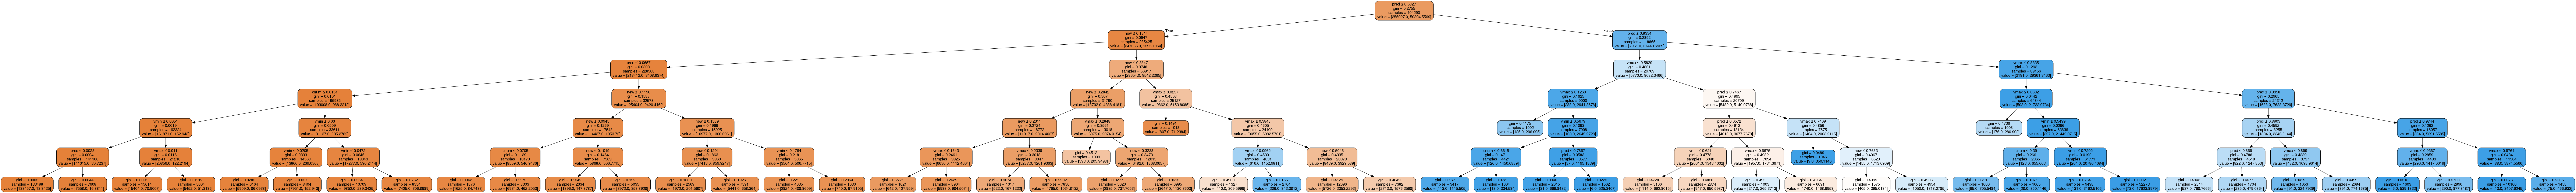

In [18]:
convert_decision_tree_to_ipython_image(final_tree, 
                                       image_filename='tree.png', 
                                       feature_names=['cnum', 'pred', 'new', 'vmax','vmin', 'vavg'])

In [19]:
df = pandas.read_csv('../data/test.csv')
submit = pandas.read_csv('submit.csv')
df['pred'] = submit['is_duplicate'].values

df2 = pandas.read_csv('../data/train.csv')
pos_rate = df2['is_duplicate'].sum() / df2.shape[0]
df2['pred'] = df2['is_duplicate'] / pos_rate * 0.165


import networkx as nx
from itertools import combinations
G = nx.Graph()

#edges = [tuple(x) for x in df[['question1', 'question2', 'pred']].values]
#G.add_weighted_edges_from(edges)
map_score = dict(((x[0], x[1]), x[2]) for x in df[['question1', 'question2', 'pred']].values)

#edges = [tuple(x) for x in df2[['question1', 'question2', 'pred']].values]
#G.add_weighted_edges_from(edges)
map_score2 = dict(((x[0], x[1]), x[2]) for x in df2[['question1', 'question2', 'pred']].values)
map_score.update(map_score2)
edges = [(k[0], k[1], v) for k, v in map_score.items()]
G.add_weighted_edges_from(edges)

import copy
cnt = 0
cliques = sorted(list(nx.find_cliques(G)), key=len) 

In [20]:
map_result = copy.deepcopy(map_score)
map_cnum = {}
map_data = {}

for cli in tqdm(cliques):
    #if len(cli) < 2:
    #    continue
    if len(cli) == 1:
        q1 = cli[0]
        print(q1)
        map_result[q1, q1] = 1.
        map_cnum[q1, q1] = 1
        map_data[q1, q1] = (1., 1., 1.)
        continue
    keys = {}
    for q1, q2 in combinations(cli, 2):
        if (q1, q2) in map_score:
            keys[q1, q2] = map_score[q1, q2]
        elif (q2, q1) in map_score:
            keys[q2, q1] = map_score[q2, q1]
        elif (q1, q2) in map_score2:
            keys[q1, q2] = map_score2[q1, q2]
        elif (q2, q1) in map_score2:
            keys[q2, q1] = map_score2[q2, q1]
        else:
            raise Exception('no edge {}'.format((q1, q2)))
    val_max = numpy.max(list(keys.values()))
    val_min = numpy.min(list(keys.values()))
    val_avg = numpy.mean(list(keys.values()))
    if val_avg > 0.4:#avg_pos:
        val = val_max
        keys = {k: numpy.max([val, map_result[k]]) for k in keys}
    elif val_avg > 0.05:
        val = val_avg
        keys = {k: numpy.max([val, map_result[k]]) for k in keys}
    else:
        val = val_min
        keys = {k: numpy.min([val, map_result[k]]) for k in keys}

    map_result.update(keys)
    keys = {k: len(cli) for k in keys}
    map_cnum.update(keys)
    keys = {k: (val_max, val_min, val_avg) for k in keys}
    map_data.update(keys)

How you've had sex?
What is annual revenue?
What does the Malayalam word mean?
How would you Google Maps?
What are the best dating in India?
What is the difference between middle school and high school?
What is boot?
What is in cricket?
What is the police code?
I universe?
What spiritual?
What training?
What is hedge fund have its back office operations in-house or outsourced to a fund admin?
How do going to gym?



In [22]:
list_val = []
list_data = []
for q1, q2 in tqdm(df[['question1', 'question2']].values):
    key = (q1, q2)
    new_pred = map_result[q1, q2]
    if key not in map_cnum:
        map_cnum[q1, q2] = 1
        map_data[q1, q2] = (new_pred, new_pred, new_pred)
    list_val.append(map_result[q1, q2])
    cnum = map_cnum.get((q1, q2), -1)
    data = list(map_data[q1, q2])
    pred = map_score[key]
    
    #'cnum', 'pred', 'new', 'vmax','vmin', 'vavg'
    list_data.append([pred, new_pred] + data)
pred = final_tree.predict_proba(list_data)[:, 1]
submit['is_duplicate'] = pred#list_val
submit.to_csv('submit_clique.csv', index=False)

In [24]:
map_dup = dict(((x[0], x[1]), x[2]) for x in df2[['question1', 'question2', 'is_duplicate']].values)
list_res = []
for key, new in map_score2.items():
    new = map_result[key]
    try:
        label = map_dup[key]
    except:
        continue
    pred = map_score2[key]
    new_pred = new
    data = list(map_data.get(key, (0, 0, 0)))
    new_pred = new
    cnum = map_cnum.get(key, 0)
    list_res.append([cnum, label, pred, new_pred] + data)

aaa = pandas.DataFrame(list_res, columns=['cnum', 'label', 'pred', 'new', 'vmax', 'vmin', 'vavg'])
from tfidf_k import calc_weight
from sklearn.metrics import log_loss, roc_auc_score
sw = calc_weight(aaa['label'].values)
print(roc_auc_score(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(roc_auc_score(aaa['label'].values, aaa['new'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['new'].values, sample_weight=sw))

1.0
0.132888890229
0.999387398223
0.112765503293


In [26]:
bbb = pandas.DataFrame(list_data, columns=[ 'pred', 'new', 'vmax', 'vmin', 'vavg'])

In [ ]:
display(bbb.groupby('new')[['new']].count().plot(kind='bar'))

In [28]:
pred = final_tree.predict_proba(bbb[['pred', 'new', 'vmax','vmin', 'vavg']])[:, 1]
bbb['new2'] = pred
#print(roc_auc_score(aaa['label'].values, aaa['new2'].values, sample_weight=sw))
#print(log_loss(aaa['label'].values, aaa['new2'].values, sample_weight=sw))

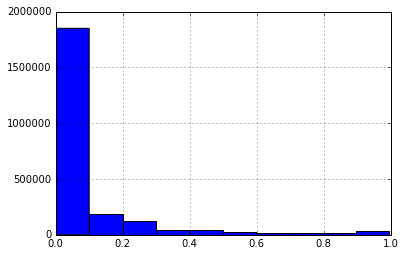

In [29]:
bbb['new2'].hist()

In [30]:
bbb

,pred,new,vmax,vmin,vavg,new2
0,0.000561,0.000561,0.000561,0.000561,0.000561,0.000104
1,0.037344,0.037344,0.037344,0.037344,0.037344,0.028531
2,0.035800,0.035800,0.035800,0.035800,0.035800,0.028531
3,0.000285,0.000285,0.000285,0.000285,0.000285,0.000104
4,0.150496,0.150496,0.150496,0.150496,0.150496,0.107940
5,0.001637,0.001637,0.001637,0.001637,0.001637,0.000104
6,0.561992,0.980408,0.980408,0.083149,0.714357,0.960225
7,0.993997,0.993997,0.993997,0.993997,0.993997,0.861606
8,0.135412,0.135412,0.135412,0.135412,0.135412,0.107940
9,0.000604,0.000604,0.000604,0.000604,0.000604,0.000104


In [35]:
pred = final_tree.predict_proba(aaa[['pred', 'new', 'vmax','vmin', 'vavg']])[:, 1]
aaa['new2'] = aaa['new2']
print(roc_auc_score(aaa['label'].values, aaa['new2'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['new2'].values, sample_weight=sw))

0.999387398223
0.112765503293


In [34]:
print(roc_auc_score(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['pred'].values , sample_weight=sw))
print(roc_auc_score(aaa['label'].values, aaa['new'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['new'].values, sample_weight=sw))

1.0
0.132888890229
0.999387398223
0.112765503293


In [ ]:
1.0
0.132888890229
0.992404179579
0.120067132942

In [46]:
aaa = pandas.DataFrame(list_data, columns=['cnum', 'pred', 'new', 'vmax', 'vmin', 'vavg'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb88f5dc320>]], dtype=object)

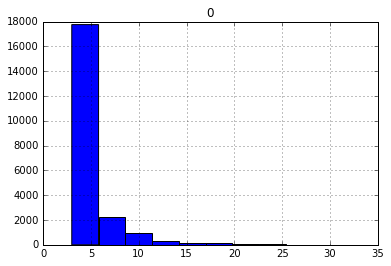

In [9]:
pandas.DataFrame([len(c) for c in cliques if len(c) > 2]).hist()

In [254]:
H = G.subgraph(clique_3)
cycls_4 = [c for c in nx.cycle_basis(H) if len(c)==3]

In [318]:
map_result2 = copy.deepcopy(map_result)
for cli in tqdm(cycls_4):
    keys = {}
    for q1, q2 in combinations(cli, 2):
        if (q1, q2) not in map_score:
            q1, q2 = q2, q1
        if (q1, q2) not in map_score:
            continue
        keys[q1, q2] = map_score[q1, q2]
    val_max = numpy.max(list(keys.values()))
    val_min = numpy.min(list(keys.values()))
    val_avg = numpy.mean(list(keys.values()))
    
    if val_avg > 0.3:# or len(cli) > 4:#avg_pos:
        val = val_max
    elif val_avg < 0.1:
        val = val_min
    else:
        val = val_avg
    keys = {k: val for k in keys}
    map_result2.update(keys)
list_res = []
for key, label in map_dup.items():
    num = map_cliques_num.get(key, -1)
    new = map_result2[key]
    pred = map_result[key]
    new_pred = new
    list_res.append((num, label, pred, new_pred))
aaa = pandas.DataFrame(list_res, columns=['cnum', 'label', 'pred', 'new'])

from tfidf_k import calc_weight
from sklearn.metrics import log_loss, roc_auc_score
sw = calc_weight(aaa['label'].values)
print(roc_auc_score(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(roc_auc_score(aaa['label'].values, aaa['new'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['new'].values, sample_weight=sw))


0.966689580396
0.169214828521
0.966286198135
0.17146878841


In [312]:
list_res = []
for key, label in map_dup.items():
    num = map_cliques_num.get(key, -1)
    new = map_result[key]
    pred = map_score[key]
    new_pred = new
    list_res.append((num, label, pred, new_pred))
aaa = pandas.DataFrame(list_res, columns=['cnum', 'label', 'pred', 'new'])

In [313]:
sw2 = sw / sw.sum() * aaa['label'].shape[0]
aaa['error'] = -1 * ( aaa['label'] * numpy.log( aaa['new']) + (1-aaa['label']) * numpy.log(1 - aaa['new']))
aaa['error_sw'] = aaa['error']  * sw2

aaa['error2'] = -1 * ( aaa['label'] * numpy.log( aaa['pred']) + (1-aaa['label']) * numpy.log(1 - aaa['pred']))
aaa['error2_sw'] = aaa['error2'] * sw2

In [314]:
aaa['tmp'] = numpy.where(aaa['cnum'] > 8, 0.9999, aaa['new'].values)
aaa['error3'] = -1 * ( aaa['label'] * numpy.log( aaa['tmp']) + (1-aaa['label']) * numpy.log(1 - aaa['tmp']))
aaa['error3_sw'] = aaa['error3'] * sw2

In [315]:
aaa.mean(axis=0).sort_values()

error_sw     0.170378
error3_sw    0.170406
error2_sw    0.183319
error3       0.242525
error        0.242847
error2       0.277560
pred         0.297521
new          0.323293
tmp          0.323808
label        0.369198
cnum         3.123248
dtype: float64

In [294]:
sw.sum()

305421.55688622763

In [296]:
aaa['label'].shape

(404290,)

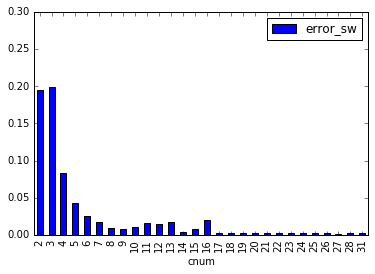

In [302]:
aaa.groupby('cnum')[['error_sw']].mean().plot(kind='bar', ylim=(0, 0.3))

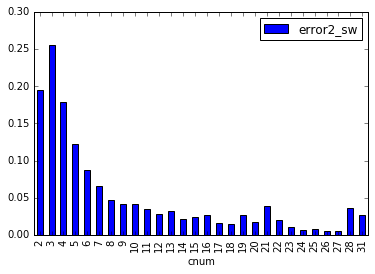

In [304]:
aaa.groupby('cnum')[['error2_sw']].mean().plot(kind='bar', ylim=(0, 0.3))

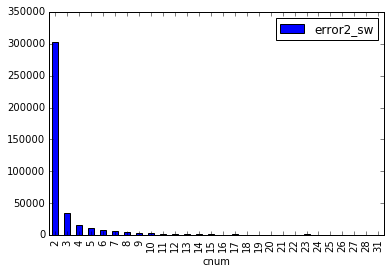

In [316]:
aaa.groupby('cnum')[['error2_sw']].count().plot(kind='bar')

In [94]:
aaa['cnum'].to_csv('train_cnum.csv', index=False)

In [27]:

G.add_weighted_edges_from([(k[0], k[1], v) for k, v in map_result.items()])
new_edges = []
for node in tqdm(G.nodes()):
    ed = G.edges(node, data=True)
    for e1, e2 in combinations(ed, 2):
        if not G.has_edge(e1[1], e2[1]):
            val = min(e1[2]['weight'], e2[2]['weight'])
            if val > 0.7:# or val < 0.01:
                new_edges.append((e1[1], e2[1], val))
G.add_weighted_edges_from(new_edges)
map_score.update(map_result)
map_score.update({(i, j): k for i,j,k in new_edges})

In [7]:
G.add_weighted_edges_from([(k[0], k[1], map_dup[k] + 1) for k, v in map_result.items()])

In [8]:
nx.write_gexf(G, "test.gexf")

In [327]:
len(set(clique_2))

501424

In [10]:
H = G.subgraph(clique_2)

In [24]:
list_aaa = []
aaa =[]
for c in nx.connected_components(H):
    if len(c) > 0:
        list_aaa.append(len(c))
    if len(c) == 1129:
        aaa += list(c)
print(max(list_aaa))
pandas.DataFrame(list_aaa).sort_values(0, ascending=False)#.hist(bins=range(15))

8327


,0
146,8327
91,1129
267,962
690,450
1581,348
468,318
2222,278
9078,277
1041,267
2345,249


In [25]:
hoge = df[df['question1'].isin(aaa) & df['question2'].isin(aaa)]

In [32]:
pandas.Series(H.degree(H.nodes())).sort_values(ascending=False)

What are the best ways to lose weight?                                                                                                                 123
How can you look at someone's private Instagram account without following them?                                                                        114
How can I lose weight quickly?                                                                                                                          83
What are some things new employees should know going into their first day at AT&T?                                                                      77
Can you see who views your Instagram?                                                                                                                   64
How do l see who viewed my videos on Instagram?                                                                                                         48
What are the best ways to reduce and eliminate belly, abdominal, and t

In [38]:
hoge = df[df['question1'].isin(['What are the best ways to lose weight?']) | df['question2'].isin(['What are the best ways to lose weight?'])]

In [42]:
ttt = [k for k, v in H.degree(H.nodes()).items() if v == 1]

In [43]:
hoge = df[df['question1'].isin(ttt) & df['question2'].isin(ttt)]

In [45]:
hoge.is_duplicate.mean()

0.2246330971659919

In [ ]:
0.169264857551
0.168754402257

In [89]:
bbb = pandas.DataFrame(data2, columns=['q1', 'q2', 'label', 'pred'])#.groupby('label').mean()
bbb['error'] = -1 * (bbb['label'] * numpy.log(bbb['pred']) + (1-bbb['label']) * numpy.log(1 - bbb['pred']))
bbb = bbb.sort_values('error', ascending=False)
bbb[bbb['error'] > 1]

,q1,q2,label,pred,error
78692,What are advantages of BITS over IIT and vice ...,Why would someone choose BITS Pilani over IIT?,1,0.000471,7.660199
10871,I got the Pokemon Y rom but I cannot find the ...,How can I play Pokemon X and Y on a PC?,1,0.000490,7.621438
154794,How do I know if a guy really likes me or just...,How can I tell the difference between a guy wh...,1,0.000540,7.523525
85884,Is it good to own a firearm?,Is it intelligent to own firearms?,1,0.000554,7.498517
268431,What were the goals of the Federalists?,What were some of the Federalist ideas?,1,0.000556,7.494267
232881,Is Algo trading by Square off reliable?,How much reliable is 100% automated Intraday t...,1,0.000569,7.471926
169871,What are the best and worst things about publi...,What are the best and worst things about publi...,1,0.000572,7.466300
227258,Do good ideas prevail?,Why can't I find good ideas?,1,0.000613,7.397454
123014,Is being a gigolo proud job for a man? What ar...,How much money can be made by being a gigolo i...,1,0.000660,7.323927
138628,Can you lay laminate over laminate?,What would happen if I installed new laminate ...,1,0.000666,7.313885


In [139]:
bbb = pandas.DataFrame(data2, columns=['q1', 'q2', 'label', 'pred'])#.groupby('label').mean()
bbb['error'] = -1 * (bbb['label'] * numpy.log(bbb['pred']) + (1-bbb['label']) * numpy.log(1 - bbb['pred']))
bbb = bbb.sort_values('error', ascending=False)
bbb[bbb['error'] > 1]

,q1,q2,label,pred,error


In [44]:
import os
from tempfile import mkstemp
import subprocess

from sklearn.tree.export import export_graphviz


def convert_decision_tree_to_ipython_image(clf, feature_names=None, class_names=None,
                                           image_filename=None, tmp_dir=None):
    dot_filename = mkstemp(suffix='.dot', dir=tmp_dir)[1]
    with open(dot_filename, "w") as out_file:
        export_graphviz(clf, out_file=out_file,
                        feature_names=feature_names,
                        class_names=class_names,
                        filled=True, rounded=True,
                        special_characters=True)

    from IPython.display import Image

    image_filename = image_filename or ('%s.png' % dot_filename)

    subprocess.call(('dot -Tpng -o %s %s' % (image_filename, dot_filename)).split(' '))
    image = Image(filename=image_filename)
    os.remove(dot_filename)
    return image

In [111]:
(data["label_rate"].values == 0 ) | (data["label_rate"].values > 0.5) 

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

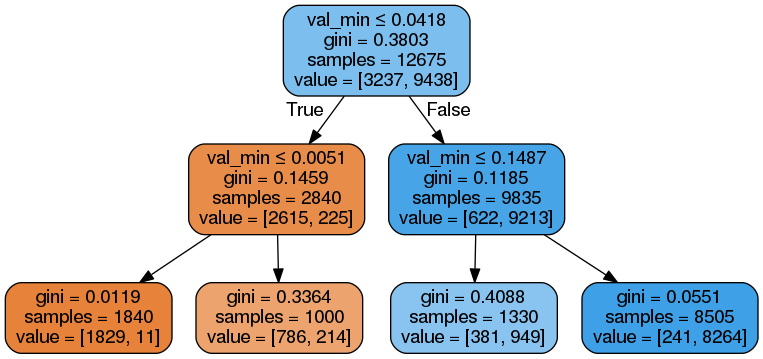

In [166]:
data = pandas.DataFrame(data, columns=["node_num", "label_num", "label_rate", "val_max", "val_min", "val_avg"])#.to_csv('cycle3_data.csv')
data['val_diff'] = data["val_max"] - data["val_min"]
data = data.dropna()
data = data[data['node_num'] == 3]
from sklearn.tree.tree import DecisionTreeClassifier
clf1 = DecisionTreeClassifier(max_depth=2, random_state=0, min_samples_leaf=1000)
clf1.fit(data[["node_num", "val_max", "val_min", "val_avg", "val_diff"]], (data["label_rate"].values > 0.5))
convert_decision_tree_to_ipython_image(clf1, image_filename='tree.png', feature_names=["node_num", "val_max", "val_min", "val_avg", "val_diff"])

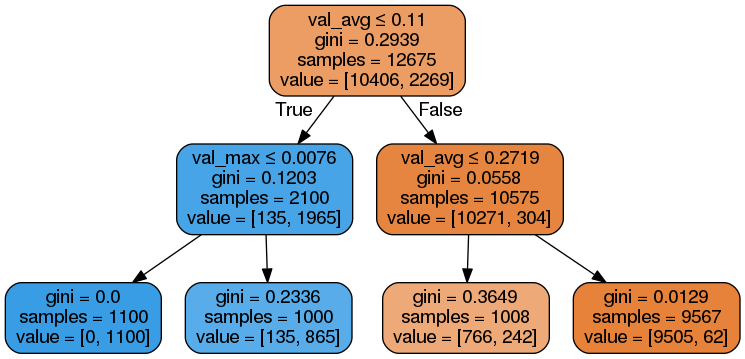

In [165]:
from sklearn.tree.tree import DecisionTreeClassifier
clf2 = DecisionTreeClassifier(max_depth=2, random_state=0, min_samples_leaf=1000)
clf2.fit(data[["node_num", "val_max", "val_min", "val_avg", "val_diff"]], (data["label_rate"].values == 0))
convert_decision_tree_to_ipython_image(clf2, image_filename='tree.png', feature_names=["node_num", "val_max", "val_min", "val_avg", "val_diff"])

In [62]:
import copy
#_map_result = copy.deepcopy(map_result)
map_result = copy.deepcopy(_map_result)

from collections import defaultdict
map_sum = defaultdict(list)
map_bet = defaultdict(list)
cnt = 0
for q1, q2, w in edges:
    try:
        cli1 = map_cliques[q1]
        cli2 = map_cliques[q2]
    except KeyError:
        continue
        
    if cli1 == cli2:
        continue
    else:
        cli1, cli2 = sorted([cli1, cli2])
        map_sum[cli1, cli2] += [w]
        map_bet[cli1, cli2] += [(q1, q2)]

In [63]:
Q = nx.Graph()
for (q1, q2), w in map_sum.items():
    val_max = numpy.max(w)
    val_min = numpy.min(w)
    val_avg = numpy.mean(w)

    Q.add_edge(q1, q2, weight=val_max)

In [64]:
for cli in nx.find_cliques(Q):
    if len(cli) < 3:
        continue
    all_edge = []
    all_weight = []
    for cli1, cli2 in combinations(cli, 2):
        
        cli1, cli2 = sorted([cli1, cli2])
        val1 = map_cliques_val[cli1]
        val2 = map_cliques_val[cli2]

        weight = Q[cli1][cli2]['weight']
        _edges = map_bet[cli1, cli2]
        
        all_weight.append(weight)
        all_edge += _edges

    if len(all_weight) == 0:
        continue
    val_max = numpy.max(all_weight)
    val_min = numpy.min(all_weight)
    val_avg = numpy.mean(all_weight)

    if val_avg > 0.5:#avg_pos:
        val = val_max
    elif val_avg > 0.3:
        val = val_avg
    else:
        val = val_min

    keys = {k: val_max for k in all_edge}
    map_result.update(keys)

In [65]:
list_res = []
for key, new in map_result.items():
    #new = map_result[key]
    try:
        label = map_dup[key]
    except:
        continue
    pred = map_score[key]
    new_pred = new
    list_res.append((label, pred, new_pred))
aaa = pandas.DataFrame(list_res, columns=['label', 'pred', 'new'])

from tfidf_k import calc_weight
from sklearn.metrics import log_loss, roc_auc_score
sw = calc_weight(aaa['label'].values)
print(roc_auc_score(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(roc_auc_score(aaa['label'].values, aaa['new'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['new'].values, sample_weight=sw))

0.960234374422
0.183290048169
0.966445009671
0.170549607845


In [17]:
len(map_cliques)

21641

In [ ]:
for cli in nx.find_cliques(GC):
    if len(cli) < 3:
        continue
    print('AAA')
    

In [2]:
df = pandas.read_csv('../data/test.csv')
submit = pandas.read_csv('submit.csv')
df['pred'] = submit['is_duplicate'].values

df2 = pandas.read_csv('../data/train.csv')
pos_rate = df2['is_duplicate'].sum() / df2.shape[0]
print(pos_rate)
#with open('tfidf_all_pred6.pkl', 'rb') as f:
#    x = pickle.load(f).astype(numpy.float32)
df2['pred'] = df2['is_duplicate'] / pos_rate * 0.165
map_dup = dict(((x[0], x[1]), x[2]) for x in df2[['question1', 'question2', 'is_duplicate']].values)

import networkx as nx
G = nx.Graph()

edges = [tuple(x) for x in df[['question1', 'question2', 'pred']].values]
G.add_weighted_edges_from(edges)
map_score = dict(((x[0], x[1]), x[2]) for x in df[['question1', 'question2', 'pred']].values)

edges = [tuple(x) for x in df2[['question1', 'question2', 'pred']].values]
G.add_weighted_edges_from(edges)
map_score2 = dict(((x[0], x[1]), x[2]) for x in df2[['question1', 'question2', 'pred']].values)

map_score.update(map_score2)
from itertools import combinations


0.369197853026293


In [5]:
import copy
cnt = 0
map_aaa = []
map_result = copy.deepcopy(map_score)
map_cliques_num = {}
#cycls_3 = [c for c in nx.cycle_basis(G) if len(c)==3]
for cli in tqdm(list(nx.find_cliques(G))):
    if len(cli) < 3:
        continue
    keys = {}
    for (q1, q2) in combinations(cli, 2):
        if (q1, q2) in map_score:
            keys[q1, q2] = map_score[q1, q2]
        elif (q2, q1) in map_score:
            keys[q2, q1] = map_score[q2, q1]

    vals = list(keys.values())
    val_max = numpy.max(vals)
    val_min = numpy.min(vals)
    val_avg = numpy.mean(vals)
    
    tmp = [[len(cli), val_max, val_min, val_avg, val_max - val_min]]
    if val_avg > 0.4:#avg_pos:
        val = val_max
    elif val_avg > 0.01:
        val = val_avg
    else:
        val = val_min
    keys = {k: val for k in keys}
    map_result.update(keys)
    keys = {k: len(cli) for k in keys}
    map_cliques_num.update(keys)

In [6]:
list_val = []
list_num = []
for q1, q2 in df[['question1', 'question2']].values:
    list_val.append(map_result[q1, q2])
    list_num.append(map_cliques_num.get((q1, q2), -1))
pandas.DataFrame(list_num).to_csv('test_cnum.csv', index=False)
submit['is_duplicate'] = list_val
submit.to_csv('submit_clique.csv', index=False)

In [7]:
list_res = []
for key, new in map_score2.items():
    new = map_result[key]
    try:
        label = map_dup[key]
    except:
        continue
    pred = map_score2[key]
    new_pred = new
    list_res.append((label, pred, new_pred))

aaa = pandas.DataFrame(list_res, columns=['label', 'pred', 'new'])
from tfidf_k import calc_weight
from sklearn.metrics import log_loss, roc_auc_score
sw = calc_weight(aaa['label'].values)
print(roc_auc_score(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['pred'].values, sample_weight=sw))
print(roc_auc_score(aaa['label'].values, aaa['new'].values, sample_weight=sw))
print(log_loss(aaa['label'].values, aaa['new'].values, sample_weight=sw))

/home/um003367/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


1.0
0.132888890229
0.999334130834
0.12160637833


In [ ]:
1.0
0.132888890229
0.992429096267
0.125606543488